# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [166]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
import matplotlib.pyplot as plt

## 2. INICIALIZAR MEDIAPIPE

In [167]:
# Configuración inicial global
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1
)
mp_draw = mp.solutions.drawing_utils
dataset_dir = "dataset_9"
model_path = "gesture_model.h5"
sequence_length = 30
total_landmarks = 126
gestures = []
X_mean = None
X_std = None

## Funciones principales

In [168]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(dataset_dir, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return [d for d in os.listdir(dataset_dir) 
           if os.path.isdir(os.path.join(dataset_dir, d))]

## DETECCION DE MANO

In [169]:
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## RECOLLECION DE DATOS 

In [170]:
def collect_data():
    global gestures
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(0)
    sequence = []
    counter = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        cv2.imshow("Recolección de Datos", frame)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")

## CARGA DE DATOS

In [171]:
def load_data():
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(dataset_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
    
    return np.array(X), np.array(y), gestures


## ENTRENAMIENTO DEL MODELO

In [172]:
def train_model():
    global X_mean, X_std, gestures
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data()
    y = tf.keras.utils.to_categorical(y)

    X_mean = np.mean(X, axis=(0, 1))
    X_std = np.std(X, axis=(0, 1))
    X = (X - X_mean) / X_std

    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = tf.keras.layers.Dense(len(gestures), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )
    model.save(model_path)
    print(f"\nModelo guardado en {model_path}")
    
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

    # Visualización del entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

## EVALUACION DEL MODELO

In [173]:
def evaluate():
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    model = load_model(model_path)
    print("\nCargando modelo y preparando evaluación...")
    
    sequence = []
    cap = cv2.VideoCapture(0)
    
    print("\nMostrando predicciones en tiempo real. Presiona 'ESC' para salir.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        
        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        else:
            sequence = []
        
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            try:
                seq_array = np.array(sequence)
                seq_array = (seq_array - X_mean) / X_std
                input_data = seq_array.reshape(1, sequence_length, total_landmarks)
                
                prediction = model.predict(input_data, verbose=0)[0]
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                
                if confidence > 0.8:
                    gesture = gestures[predicted_class]
                    cv2.putText(frame, f"{gesture} ({confidence:.2%})", (10, 50),
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            except Exception as e:
                print(f"\nError en predicción: {str(e)}")
                break

        cv2.imshow("Predicciones en Tiempo Real", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## REENTRENAR GESTO

In [174]:
def retrain_gesture():
    global gestures
    if not gestures:
        print("\nNo hay gestos para reentrenar. Primero recolecte datos.")
        return

    print("\nGestos disponibles para reentrenar:")
    for i, gesture in enumerate(gestures):
        print(f"{i+1}. {gesture}")

    try:
        choice = int(input("\nSeleccione el número del gesto a reentrenar: ")) - 1
        if 0 <= choice < len(gestures):
            gesture = gestures[choice]
            gesture_dir = os.path.join(dataset_dir, gesture)
            
            for file in os.listdir(gesture_dir):
                os.remove(os.path.join(gesture_dir, file))
            
            print(f"\nDatos anteriores de '{gesture}' eliminados.")
            collect_data()
            train_model()
        else:
            print("\nSelección inválida.")
    except ValueError:
        print("\nPor favor, ingrese un número válido.")

## MENU

In [175]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo")
        print("4. Evaluar")
        print("5. Reentrenar Gesto")
        print("6. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            collect_data()
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            retrain_gesture()
        elif choice == '6':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

Cargando datos y preparando el entrenamiento...

Iniciando entrenamiento...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.2695 - loss: 2.1438 - val_accuracy: 0.0000e+00 - val_loss: 2.5525
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6806 - loss: 1.9391 - val_accuracy: 0.0000e+00 - val_loss: 2.5166
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8306 - loss: 1.8261 - val_accuracy: 0.0000e+00 - val_loss: 2.4937
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9073 - loss: 1.6641 - val_accuracy: 0.0000e+00 - val_loss: 2.4678
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9051 - loss: 1.6100 - val_accuracy: 0.0000e+00 - val_loss: 2.4431
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9273 - loss: 1.4893 - val_accuracy: 0.0000e+00 - val_loss: 2.


Modelo guardado en gesture_model.h5
Precisión de validación final: 100.00%


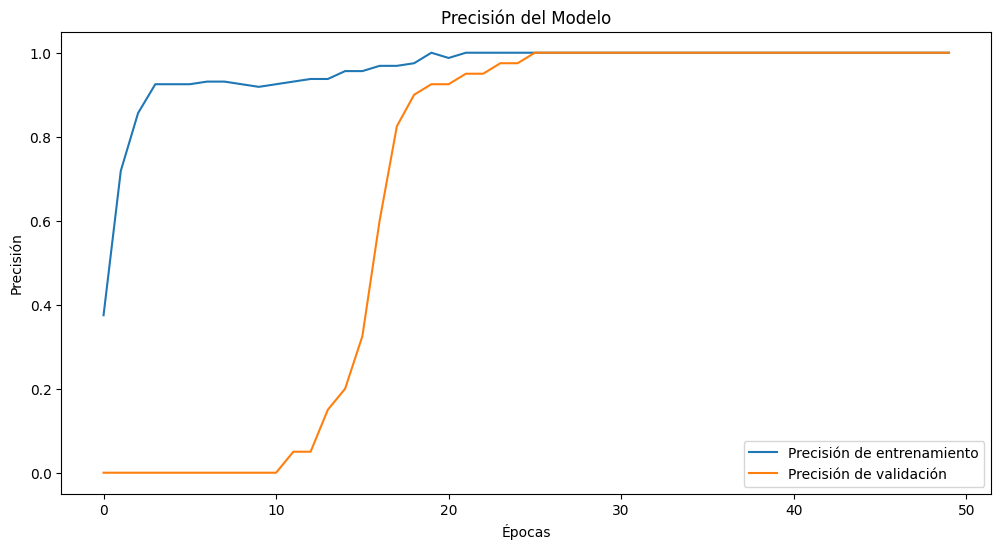

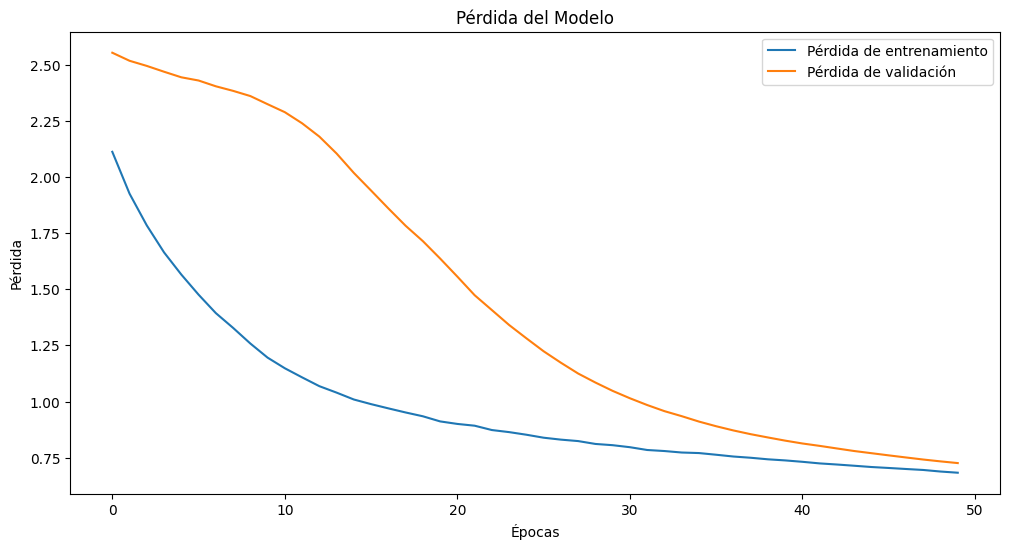


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir



Cargando modelo y preparando evaluación...

Mostrando predicciones en tiempo real. Presiona 'ESC' para salir.

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

Recolectando datos para el gesto 'DE NADA'. Presiona 'ESC' para cancelar.
Mantenga la seña frente a la cámara...
Secuencias capturadas: 1/50
Secuencias capturadas: 2/50
Secuencias capturadas: 3/50
Secuencias capturadas: 4/50
Secuencias capturadas: 5/50
Secuencias capturadas: 6/50
Secuencias capturadas: 7/50
Secuencias capturadas: 8/50
Secuencias capturadas: 9/50
Secuencias capturadas: 10/50
Secuencias capturadas: 11/50
Secuencias capturadas: 12/50

Se recolectaron 12 secuencias para el gesto 'DE NADA'

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

Recolectando datos para el gesto 'DE NADA'. Presiona 'ESC' para cancelar.



Modelo guardado en gesture_model.h5
Precisión de validación final: 0.00%


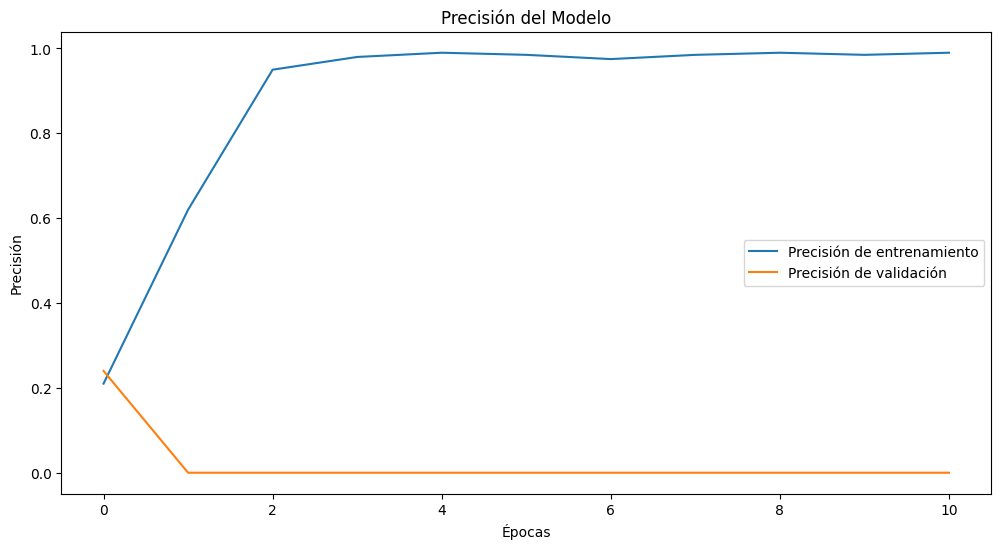

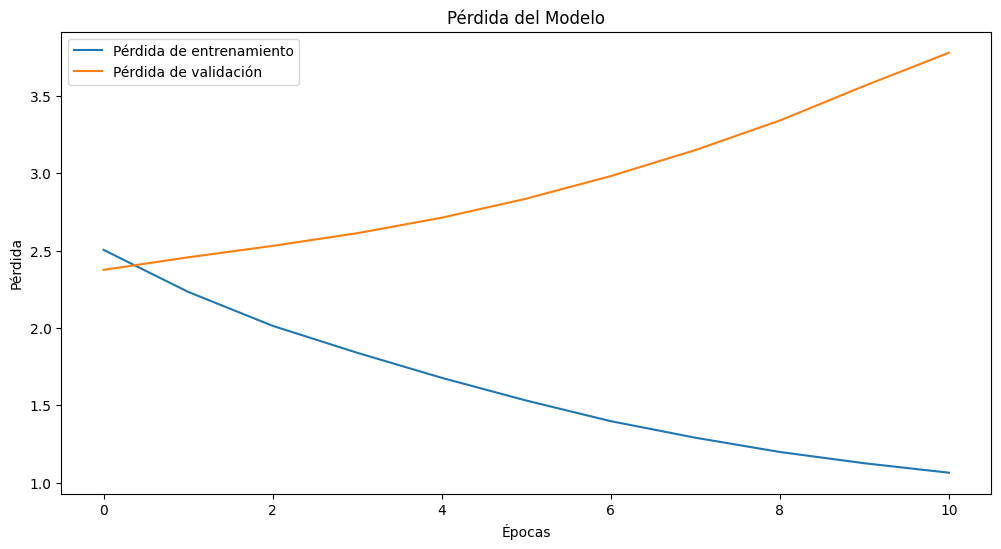


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

¡Hasta luego!


In [176]:
if __name__ == "__main__":
    main()